In [104]:
import os
import cv2
import numpy as np
import time

In [105]:
model_id = "face"
CFG_FILE_ABS_PATH = "C:/WORK/wamp/www/DataFolders/face_mask/yolov4-custom.cfg"
WEIGHTS_FILE_ABS_PATH = "C:/WORK/wamp/www/model_store/yolov4/training/yolov4-custom_last.weights"
image_file = 'C:/WORK/wamp/www/DataFolders/face_mask/data/obj/0.jpg'
#classes = ['with_mask','without_mask']
#size=416

inference_path="C:\WORK\wamp\www\DataFolders\check_marks\inference"

#model_id = "custom2"
#CFG_FILE_ABS_PATH = "C:/WORK/wamp/www/DataFolders/check_marks/yolov4/train/yolov4-custom.cfg"
#WEIGHTS_FILE_ABS_PATH = "C:/WORK/wamp/www/model_store/CHECK_MARKS/yolov4/yolov4-custom_3000.weights"

#model_id = "swish"
#CFG_FILE_ABS_PATH = "C:/WORK/wamp/www/DataFolders/check_marks/yolov4/train/yolov4-csp-x-swish.cfg"
#WEIGHTS_FILE_ABS_PATH = "C:/WORK/wamp/www/model_store/CHECK_MARKS/yolov4/yolov4-csp-x-swish_1000.weights"

#model_id = "swish_ema"
#CFG_FILE_ABS_PATH = "C:/WORK/wamp/www/DataFolders/check_marks/yolov4/train/yolov4-csp-x-swish.cfg"
#WEIGHTS_FILE_ABS_PATH = "C:/WORK/wamp/www/model_store/CHECK_MARKS/yolov4/yolov4-csp-x-swish_ema.weights"


#image_file = 'C:/WORK/wamp/www/DataFolders/check_marks/fiftyone/test/76ee9bf8-1c7e-11ec-84f5-6a6fe3555739_1.jpg'
#image_file = 'C:/WORK/wamp/www/DataFolders/check_marks/data/10Test/cff02082-17f1-11ec-8704-ba71947cd777_2.jpg'
classes = ['checked','unchecked']
size=576
net = cv2.dnn.readNet(WEIGHTS_FILE_ABS_PATH, CFG_FILE_ABS_PATH)


In [106]:
def get_output_layers(net):
    layer_names = net.getLayerNames()

    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

In [107]:

image = cv2.imread(image_file)
height, width = image.shape[:2]
scale = 0.00392

confidence=0.05
nms_thresh=0.5

In [108]:
blob = cv2.dnn.blobFromImage(image, scale, (size,size), (0,0,0), True, crop=False)

In [109]:
net.setInput(blob)

start = time.time()
outs = net.forward(get_output_layers(net))
end = time.time()
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 0.650000 seconds


In [110]:

class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        max_conf = scores[class_id]
        if max_conf > confidence:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = center_x - (w / 2)
            y = center_y - (h / 2)
            class_ids.append(class_id)
            confidences.append(float(max_conf))
            boxes.append([x, y, w, h])

indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence, nms_thresh)


In [111]:
bbox = []
labels = []
conf = []
if len(indices) > 0:
    for i in indices.flatten():
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        bbox.append([int(x), int(y), int(x+w), int(y+h)])
        labels.append(str(classes[class_ids[i]]))
        conf.append(confidences[i])


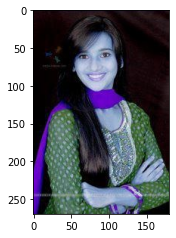

In [112]:
import matplotlib.pyplot as plt
import matplotlib
dpi = matplotlib.rcParams['figure.dpi']
figsize = width / float(dpi), height / float(dpi)
plt.figure(figsize=figsize)
plt.imshow(image)
plt.show()



In [113]:
COLORS = np.random.uniform(0, 255, size=(80, 3))
colors = None
write_conf = True
for i, label in enumerate(labels):
    if colors is None:
        color = COLORS[classes.index(label)]
    else:
        color = colors[classes.index(label)]

    #if write_conf:
    #    label += ' ' + str(format(conf[i] * 100, '.2f')) + '%'
    label = ""

    cv2.rectangle(image, (bbox[i][0],bbox[i][1]), (bbox[i][2],bbox[i][3]), color, 2)
    cv2.putText(image, label, (bbox[i][0],bbox[i][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


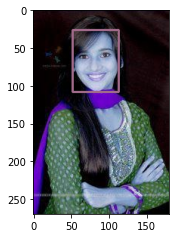

In [114]:
dpi = matplotlib.rcParams['figure.dpi']
figsize = width / float(dpi), height / float(dpi)
fig = plt.figure(figsize=figsize)
plt.imshow(image)
plt.show()
fig.savefig(os.path.join(inference_path, model_id + "_test.png"))